# Informações iniciais
__[Datasets utilizados](https://drive.google.com/drive/u/1/folders/1cC5KcQWQLhCAb2WheeAd8HYZ5v4u9Uej)__

Descrição das features: 
- **employee_id**: ID único do funcionário;
- **department**: departamento do funcionário;
- **region**: região de emprego (não ordenada);
- **education**: nível educacional do funcionário;
- **gender**: gênero do funcionário;
- **recruitment_channel**: canal de recrutamento para o funcionário;
- **no_ of_ trainings**: número de treinamentos completados em anos passados,
sejam em soft skills, technical skills, etc;
- **age**: idade do funcionário;
- **previous_ year_ rating**: avaliação do funcionário para o ano anterior;
- **length_ of_ service**: duração do serviço em anos;
- **awards_ won?**: se ganhou algum prêmio em anos anteriores, recebe 1, do
contrário 0;
- **avg_ training_ score**: pontuação média nas avaliações de treinamento atuais.

Descrição do Target:
- **is_promoted**: recomendado ou não para promoção.

## Setup
Importação das bibliotecas necessárias para análises e dos datasets estudados.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dfTrain = pd.read_csv('train.csv')
dfTest = pd.read_csv('test.csv')

# Análise inicial
Primeiramente, a fim de termos análise e limpeza mais precisas, juntaremos os datasets. Feito isso, teremos uma breve ideia de como estão distribuídas as repostas no dataset.

In [ ]:
dfAnalise = pd.merge(dfTrain, dfTest, how='outer') # Junção dos datasets
dfAnalise.set_index('employee_id', inplace=True) # O ID do funcionário funciona apenas como identificação, assim, servirá como o índice, apenas, do dataset
dfAnalise.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1.0,35,5.0,8,0,49.0,0.0
65141,Operations,region_22,Bachelor's,m,other,1.0,30,5.0,4,0,60.0,0.0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1.0,34,3.0,7,0,50.0,0.0
2542,Sales & Marketing,region_23,Bachelor's,m,other,2.0,39,1.0,10,0,50.0,0.0
48945,Technology,region_26,Bachelor's,m,other,1.0,45,3.0,2,0,73.0,0.0


In [ ]:
dfAnalise.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78298 entries, 65438 to 5973
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            78298 non-null  object 
 1   region                78298 non-null  object 
 2   education             74855 non-null  object 
 3   gender                78298 non-null  object 
 4   recruitment_channel   78298 non-null  object 
 5   no_of_trainings       71379 non-null  float64
 6   age                   78298 non-null  int64  
 7   previous_year_rating  72362 non-null  float64
 8   length_of_service     78298 non-null  int64  
 9   awards_won?           78298 non-null  int64  
 10  avg_training_score    70840 non-null  float64
 11  is_promoted           54808 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 7.8+ MB


In [ ]:
# Quantidade de NAN's por coluna
dfAnalise.isnull().sum()

department                  0
region                      0
education                3443
gender                      0
recruitment_channel         0
no_of_trainings          6919
age                         0
previous_year_rating     5936
length_of_service           0
awards_won?                 0
avg_training_score       7458
is_promoted             23490
dtype: int64

In [ ]:
# Porcentagem de observações com dados faltantes no datasets, sem contar os dados faltantes do target
tamanhoInicial = dfAnalise.shape[0]
tamanhoFinal = dfAnalise.dropna(subset=['education', 'no_of_trainings', 'previous_year_rating', 'avg_training_score']).shape[0]
print(f"{(100*(1-(tamanhoFinal/tamanhoInicial))):.2f} por cento de observações com dados faltantes no datasets")

22.16 por cento de observações com dados faltantes no datasets


Analisando as informações obtidas, percebemos que as features **education**, **no_of_trainings**, **previous_year_rating** e **avg_training_score** têm dados faltantes, sendo a **avg-training_score** com mais dados desse tipo. Como temos que as observações com dados faltantes representam 22,15% do total de observações, não podemos simplesmente descartar tais dados, sendo necessário analisar caso a caso o que fazer com eles. Em **is_promoted**, o número de observações não nulas é menor que o número de observações totais, pois o dataset de teste, `dfTest`, por definição, não tem a coluna target. Além  Observamos, também, os tipos de dados de cada coluna do dataset, localizados em *Dtype*, e, com isso, temos que **awards_won?** e **is_promoted**, por terem como resposta 1 ou 0, foram classificadas como numéricas, quando se tratam de dados categóricos. Assim, é necessário fazer tal correção.

In [ ]:
dfAnalise = dfAnalise.astype({'awards_won?': object, 'is_promoted': object}, copy=False)
dfAnalise.dtypes

department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings         float64
age                       int64
previous_year_rating    float64
length_of_service         int64
awards_won?              object
avg_training_score      float64
is_promoted              object
dtype: object

Agora, divideremos a nossa análise entre dados categóricos e numéricos,  começando pelos categóricos. 
# Análise dos dados categóricos

Primeiramente, vamos fazer uma análise inicial dos dados categóricos a fim de termos uma noção geral de cada feature e levantar hipóteses de possíveis erros em certas colunas.

In [ ]:
dfAnalise.describe(include='object')

,department,region,education,gender,recruitment_channel,awards_won?,is_promoted
count,78298,78298,74855,78298,78298,78298,54808.0
unique,10,35,3,5,3,2,2.0
top,Sales & Marketing,region_2,Bachelor's,m,other,0,0.0
freq,24155,17642,52247,50232,43524,76493,50140.0


Observando os valores, temos um ponto que chama atenção:
- A resposta que mais aparece em **recruitment_chanel** é other, o que, por tal resposta ser muito geral, indica que tal feature pode vir a ser menos relevante que outras no impacto da target, pois a maioria de suas respostas são pouco explicativas.

Visto isso, vamos analisar mais a fundo cada um dos dados agora.
## Análise de **department**

In [ ]:
dfAnalise['department'].unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal',
       'quem trouxe quenga'], dtype=object)

Analisando os tipos de respostas acima, é notável que temos respostas imprecisas/não condizentes com o que a feature representa, sendo essas 'Legal' e 'quem trouxe quenga'. Assim, vamos analisar quantas respostas desse tipo temos para decidirmos como iremos tratá-las.

In [ ]:
dfAnalise['department'].value_counts()

Sales & Marketing     24155
Operations            16112
Procurement           10158
Technology            10149
Analytics              7671
Finance                3627
HR                     3503
Legal                  1452
R&D                    1439
quem trouxe quenga       32
Name: department, dtype: int64

Temos, portanto, 32 respostas 'quem trouxe quenga', o que representa cerca de 0,04% do número de observações($\frac{32}{78298} \approx$ 0.04%),e 1452 respostas 'Legal', aproximadamente 1,85% do número de observações($\frac{1452}{78298} \approx$ 1,85%). Como a quantidade de respostas 'quem trouxe quenga' é muito pequena proporcionalmente, iremos descartar tais observações, já a de respostas 'Legal' é razoável, por isso, vamos substituir tal resposta pela moda, ao invés de descartar tais dados, pois, nesse caso, o acréscimo das respostas 'Legal' na moda não afeta tanto a análise dessa.

In [ ]:
dfAnalise.drop(dfAnalise[dfAnalise['department'] == 'quem trouxe quenga'].index, inplace=True)
dfAnalise['department'].replace('Legal', dfAnalise['department'].mode()[0], inplace=True)

Agora que já tratamos os dados dessa feature, vamos analisá-la.

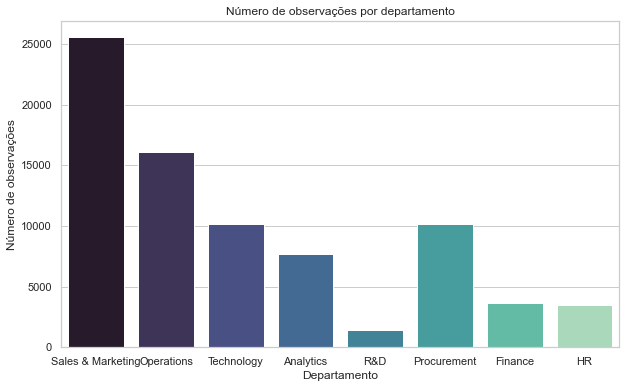

In [ ]:
plt.figure(figsize=[10,6])
sns.set_theme(style='whitegrid')
sns.countplot(data=dfAnalise, x='department', palette='mako')
plt.title('Número de observações por departamento')
plt.xlabel('Departamento')
plt.ylabel('Número de observações')
plt.show()

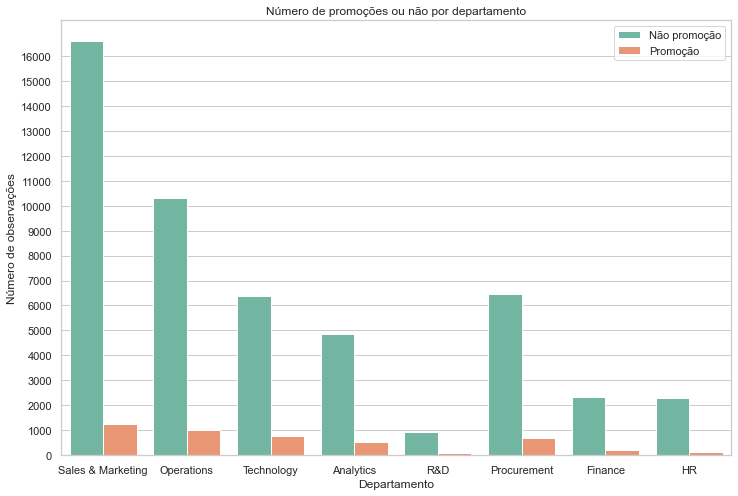

In [ ]:
plt.figure(figsize=[12,8])
ticks = list()
for i in range(17):
    ticks.append(i*1000)
plt.yticks(ticks)
sns.countplot(data=dfAnalise, x='department', hue='is_promoted', palette='Set2')
plt.legend(['Não promoção', 'Promoção'])
plt.title('Número de promoções ou não por departamento')
plt.xlabel('Departamento')
plt.ylabel('Número de observações')
plt.show()

In [ ]:
# Porcentagem de promoções para cada resposta
print((dfAnalise['department'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['department'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False))

Technology           10.759316
Procurement           9.638554
Analytics             9.566517
Operations            9.014804
Finance               8.123028
Sales & Marketing     7.051641
R&D                   6.906907
HR                    5.624483
Name: department, dtype: float64


Analisando os dados acima, temos que _Sales & Marketing_ é o departamento com maior número de observações e com mais promoções também. Ademais, nos departamentos _R&D_, _Finance_ e _HR_, praticamente, não temos promoções observadas, enquanto os outros têm quantidades similares de promoção, em torno de mil para _Sales & Marketing_ e _Operations_; um pouco  menos que mil _Tecnology_, _Analytics_ e _Procurement_. Finalmente, temos que _HR_ é o departamento com menos promoções relativas, e _Technology_ o com mais.
## Análise de **region**

In [ ]:
dfAnalise['region'].unique()

array(['region_7', 'region_22', 'region_19', 'region_23', 'region_26',
       'region_2', 'region_20', 'region_34', 'region_1', 'region_4',
       'region_29', 'region_31', 'region_15', 'region_14', 'region_11',
       'region_5', 'region_28', 'region_17', 'region_13', 'region_16',
       'region_25', 'region_10', 'region_27', 'region_30', 'region_12',
       'region_21', 'region_8', 'region_32', 'region_6', 'region_33',
       'region_24', 'region_3', 'region_9', 'region_18',
       'casa da lu na suecia'], dtype=object)

Analisando as regiões acima, percebe-se que 'casa da lu na suecia' distoa do padrão existente no restante das respostas. Similar ao que foi feito anteriormente, veremos quantas observações desse tipo temos para tomarmos uma decisão sobre como tratá-las.

In [ ]:
len(dfAnalise[dfAnalise['region'] == 'casa da lu na suecia'])

6

Como temos apenas 6 observações desse tipo, quantidade insignificante perto da quantidade total de observações, iremos descartar tais dados para análise. 

In [ ]:
dfAnalise.drop(dfAnalise[dfAnalise['region'] == 'casa da lu na suecia'].index, inplace=True)

Feito isso, podemos analisar a feature.

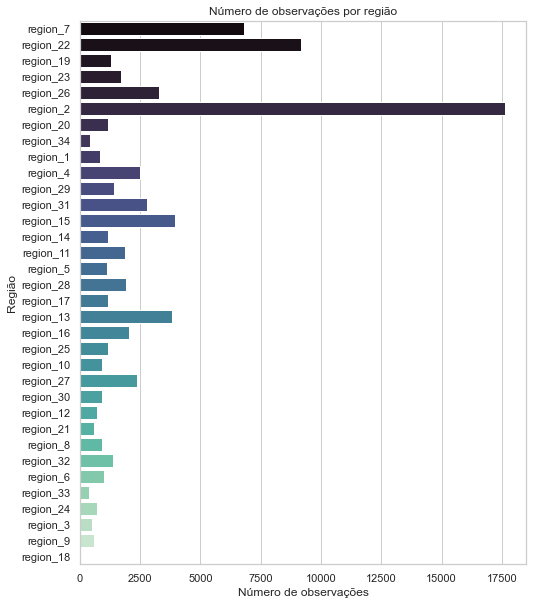

In [ ]:
plt.figure(figsize=[8,10])
sns.countplot(data=dfAnalise, y='region',palette='mako')
plt.title('Número de observações por região')
plt.xlabel('Número de observações')
plt.ylabel('Região')
plt.show()

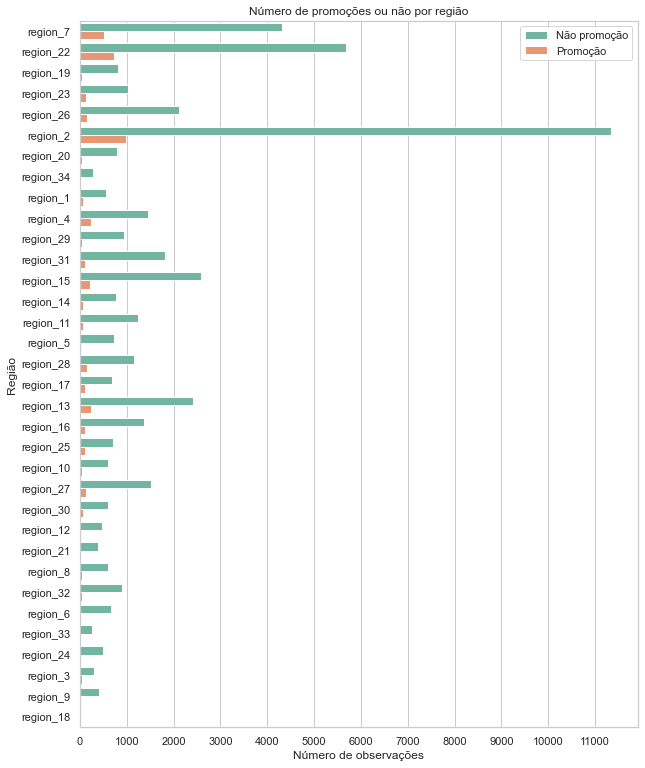

In [ ]:
plt.figure(figsize=[10,13])
ticks = list()
for i in range(13):
    ticks.append(i*1000)
plt.xticks(ticks)
sns.countplot(data=dfAnalise, y='region', hue='is_promoted', palette='Set2')
plt.legend(['Não promoção', 'Promoção'])
plt.title('Número de promoções ou não por região')
plt.xlabel('Número de observações')
plt.ylabel('Região')
plt.show()

In [ ]:
# Porcentagem de promoções para cada resposta
dfPromocoesRel = (dfAnalise['region'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['region'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False)
print(dfPromocoesRel.head(5))
print(dfPromocoesRel.tail(4))

region_4     14.445097
region_17    13.693467
region_25    12.576313
region_28    11.684370
region_23    11.659574
Name: region, dtype: float64
region_24    3.543307
region_18    3.225806
region_34    2.777778
region_9     1.904762
Name: region, dtype: float64


Temos que a quantidade de pessoas que moram nas regiões 2, 7 e 22 é bem superior a quantidade presente nas outras regiões. São nas regiões destacadas que temos, também, a maior quantidade de promoções, entretanto, vemos que, em número relativos, essas não estão nem entre as 5 com os maiores números. Vemos também que enquanto existem regiões com, aproximadamente, 2% de promoções, existem outras com quase 14,5%, portanto, verificamos que a região tem uma influência na promoção.
## Análise de **education**

In [ ]:
dfAnalise['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

Observando a informação acima, temos que todas as respostas são condizentes com a feature, assim, temos que tratar apenas dos dados faltantes. Como visto na Análise inicial, em **education** temos 3443 observações com dados faltantes, o que representa cerca de 4,40%($\frac{3443}{78298} \approx$ 4,40%), assim, não vamos desprezar esses dados, pois perderíamos bastante informação. Por isso, vamos analisar a distribuição das respostas da feature para decidir o que fazer quanto aos dados faltantes.

In [ ]:
dfAnalise['education'].value_counts()

Bachelor's          52215
Master's & above    21423
Below Secondary      1179
Name: education, dtype: int64

Como a moda tem um número de observações igual a 52215, substituir os dados faltantes pela moda não impactará tão intensamente nos resultados de tal resposta.

In [ ]:
dfAnalise['education'].fillna(dfAnalise['education'].mode()[0], inplace=True)

Isso feito, vamos analisar a feature agora.

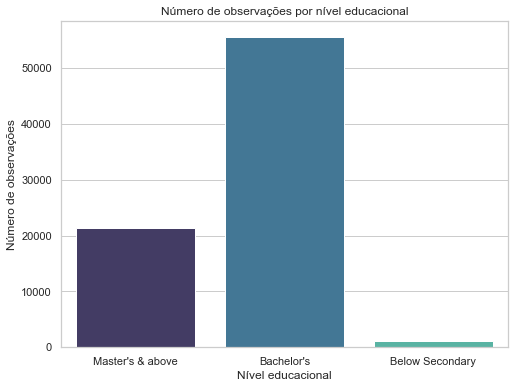

In [ ]:
plt.figure(figsize=[8,6])
sns.countplot(data=dfAnalise, x='education',palette='mako')
plt.title('Número de observações por nível educacional')
plt.ylabel('Número de observações')
plt.xlabel('Nível educacional')
plt.show()

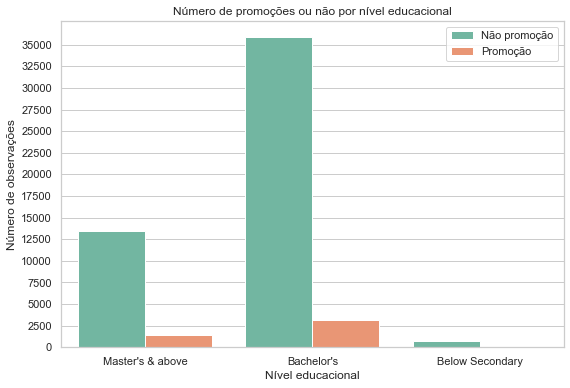

In [ ]:
plt.figure(figsize=[9,6])
ticks = list()
for i in range(15):
    ticks.append(i*2500)
plt.yticks(ticks)
sns.countplot(data=dfAnalise, x='education', hue='is_promoted', palette='Set2')
plt.legend(['Não promoção', 'Promoção'])
plt.title('Número de promoções ou não por nível educacional')
plt.ylabel('Número de observações')
plt.xlabel('Nível educacional')
plt.show()

In [ ]:
# Porcentagem de promoções para cada resposta
print((dfAnalise['education'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['education'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False))

Master's & above    9.858589
Below Secondary     8.322981
Bachelor's          7.996825
Name: education, dtype: float64


Percebe-se, como já visto anteriormente, que a maioria das observações têm nível educacional _Bachelor's_. Temos ainda que pessoas com nível de educação _Below Secondary_, relativamente, é mais promovida que as com nível _Bachelor's_, o que acontece devido a quantidade de observações de tal resposta ser muito baixa. Por fim, vemos que a com maior índice de promoção é _Masters's & Above_. Como as respostas têm números relativos de promoções bem próximos, concluímos que tal feature não influencia tanto para promoção. 

## Análise de **gender**

In [ ]:
dfAnalise['gender'].unique()

array(['f', 'm', 'MALE', 'fEMALE', 'eu sou homem hetero homossexual!'],
      dtype=object)

In [ ]:
dfAnalise['gender'].value_counts()

m                                   50203
f                                   22381
MALE                                 4631
fEMALE                                821
eu sou homem hetero homossexual!      224
Name: gender, dtype: int64

Analisando a informação acima, temos que existem representações diferentes para uma mesma resposta, 'm' e 'MALE'; e 'f' e 'fEMALE', e que 'eu sou homem hetero homossexual!' não informa o gênero do indivíduo, assim, vamos corrigir isso juntando as representações equivalentes em uma mesma resposta e, como temos poucos dados com 'eu sou homem hetero homossexual!', iremos descartar tais dados.

In [ ]:
dfAnalise['gender'].replace('m', 'MALE', inplace=True)
dfAnalise['gender'].replace('f', 'FEMALE', inplace=True)
dfAnalise['gender'].replace('fEMALE', 'FEMALE', inplace=True)
dfAnalise.drop(dfAnalise[dfAnalise['gender'] == 'eu sou homem hetero homossexual!'].index, inplace=True)

Agora com a alteração feita, vamos analisar a feature.

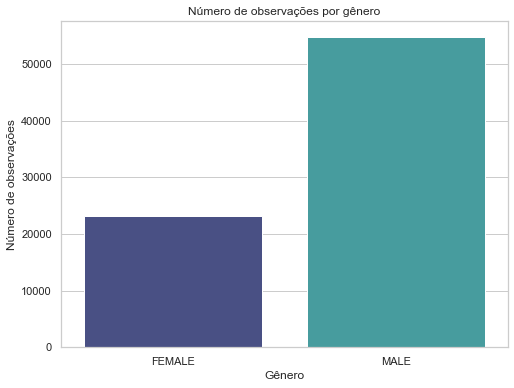

In [ ]:
plt.figure(figsize=[8,6])
sns.countplot(data=dfAnalise, x='gender',palette='mako')
plt.title('Número de observações por gênero')
plt.ylabel('Número de observações')
plt.xlabel('Gênero')
plt.show()

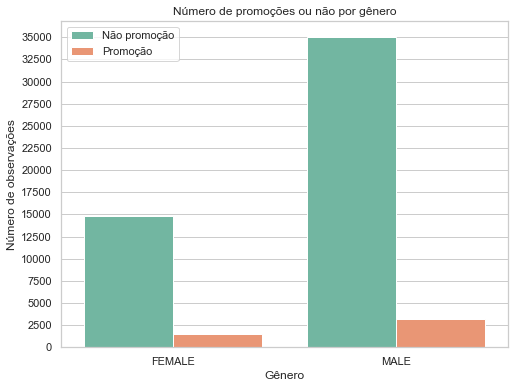

In [ ]:
plt.figure(figsize=[8,6])
ticks = list()
for i in range(15):
    ticks.append(i*2500)
plt.yticks(ticks)
sns.countplot(data=dfAnalise, x='gender', hue='is_promoted', palette='Set2')
plt.legend(['Não promoção', 'Promoção'])
plt.title('Número de promoções ou não por gênero')
plt.ylabel('Número de observações')
plt.xlabel('Gênero')
plt.show()

In [ ]:
# Porcentagem de promoções para cada resposta
print((dfAnalise['gender'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['gender'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False))

FEMALE    8.995033
MALE      8.327668
Name: gender, dtype: float64


Analisando o gráfico observa-se que a maioria das observações pertencem ao gênero masculino. Entretanto, ao analisarmos relativamente a distribuição de promoções, temos que os números são bem parecidos entre os gêneros, e que, por isso, não influencia tanto na promoção.
## Análise de **recruitment_channel**

In [ ]:
dfAnalise['recruitment_channel'].unique()

array(['sourcing', 'other', 'referred'], dtype=object)

Temos que todas as respostas são condizentes com a categoria, entretanto, _other_ é muito abrangente, ou seja, não traz nenhuma informação relevante. Mas vamos continuar a análise sem tratar tal resposta, por ora, pois caso as promoções estejam concentradas nas outras categorias e _other_ não tenha tantas promoções, podemos considerar que o importante para promoção está nas outras categorias.  

In [ ]:
dfAnalise['recruitment_channel'].value_counts()

other       43361
sourcing    33083
referred     1592
Name: recruitment_channel, dtype: int64

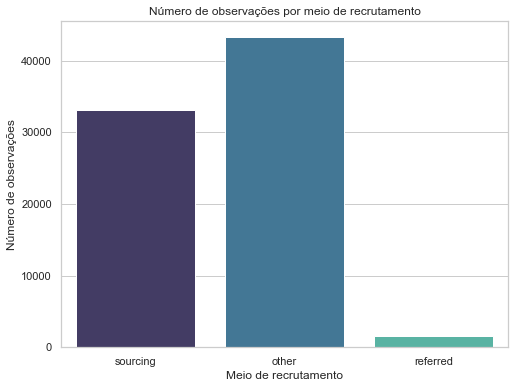

In [ ]:
plt.figure(figsize=[8,6])
sns.countplot(data=dfAnalise, x='recruitment_channel',palette='mako')
plt.title('Número de observações por meio de recrutamento')
plt.ylabel('Número de observações')
plt.xlabel('Meio de recrutamento')
plt.show()

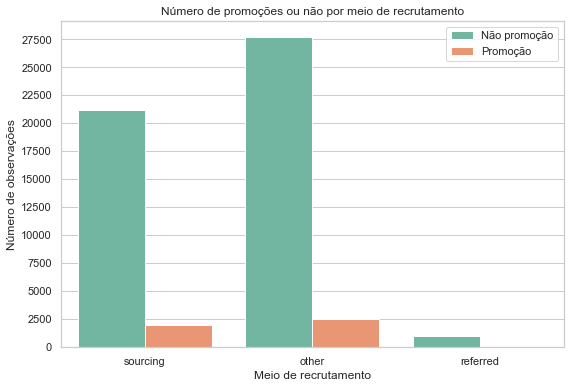

In [ ]:
plt.figure(figsize=[9,6])
ticks = list()
for i in range(12):
    ticks.append(i*2500)
plt.yticks(ticks)
sns.countplot(data=dfAnalise, x='recruitment_channel', hue='is_promoted', palette='Set2')
plt.legend(['Não promoção', 'Promoção'])
plt.title('Número de promoções ou não por meio de recrutamento')
plt.ylabel('Número de observações')
plt.xlabel('Meio de recrutamento')
plt.show()

In [ ]:
# Porcentagem de promoções para cada resposta
print((dfAnalise['recruitment_channel'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['recruitment_channel'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False))

referred    12.084063
sourcing     8.522875
other        8.396342
Name: recruitment_channel, dtype: float64


Analisando as informações, temos que, _other_ é a que mais tem promoções. Entretanto, vemos que tal resposta é a que menos tem promoções, relativamente, enquanto a que tem mais é _referred_.

## Análise de **awards_won?**

In [ ]:
dfAnalise['awards_won?'].unique()

array([0, 1], dtype=object)

Vemos que todas as respostas são condizentes com a feature. Agora, partiremos para sua análise

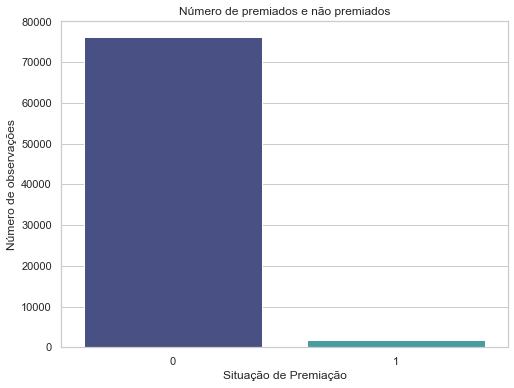

In [ ]:
plt.figure(figsize=[8,6])
sns.countplot(data=dfAnalise, x='awards_won?',palette='mako')
plt.title('Número de premiados e não premiados')
plt.ylabel('Número de observações')
plt.xlabel('Situação de Premiação')
plt.show()

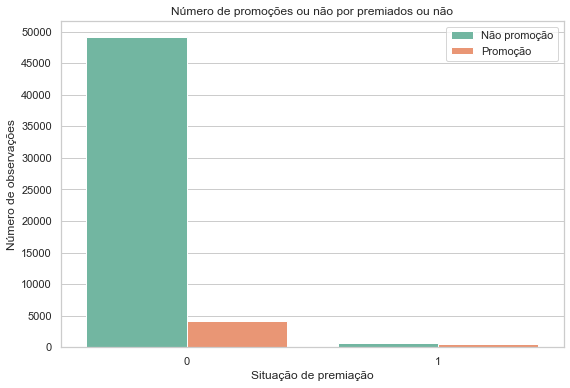

In [ ]:
plt.figure(figsize=[9,6])
ticks = list()
for i in range(11):
    ticks.append(i*5000)
plt.yticks(ticks)
sns.countplot(data=dfAnalise, x='awards_won?', hue='is_promoted', palette='Set2')
plt.legend(['Não promoção', 'Promoção'])
plt.title('Número de promoções ou não por premiados ou não')
plt.ylabel('Número de observações')
plt.xlabel('Situação de premiação')
plt.show()

In [ ]:
# Porcentagem de promoções para cada resposta
print((dfAnalise['awards_won?'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['awards_won?'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False))

1    44.471348
0     7.691875
Name: awards_won?, dtype: float64


Percebe-se que a imensa maioria de pessoas pertencem aos grupos de não premiados. Entretanto, o que surpreende é a quantidade de promoções dentro do grupo de pessoas premiadas, em que quase metade desse foi promovido. Assim, tem-se que tal feature pode influenciar bastante na promoção de uma pessoa.
## Conclusões sobre análises dos dados categóricos

Após as análises, podemos concluir que **awards_won?** é, das features analisadas, a que mais tem impacto na promoção ou não de um candidato, enquanto **gender** é a que menos influencia para isso. Temos também que **region** e **department** devem ter impacto considerável para promoção, já as demais devem ter pouco impacto.

# Análise de dados numéricos
Vamos ter uma noção geral dos dados numéricos antes de analisá-los individualmente.

In [ ]:
dfAnalise.describe(include=np.number)

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score
count,71120.000000,78036.000000,72110.000000,78036.000000,70581.000000
mean,1.257199,202.453304,3.333102,5.846238,63.420524
std,0.611059,4545.727728,1.261423,4.245325,13.463232
min,1.000000,-32.000000,1.000000,1.000000,39.000000
25%,1.000000,29.000000,3.000000,3.000000,51.000000
50%,1.000000,33.000000,3.000000,5.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,76.000000
max,10.000000,123456.000000,5.000000,37.000000,99.000000


Analisando as estatísticas geradas, observamos que temos respostas imprecisas em **age**, pois não é possível termos alguém com idade negativa, nem com idade superior a mil anos, por exemplo. Fora isso, podemos observar que as respostas presentes nas outras features são condizentes, entretanto, temos **no_of_trainings, previous_year_rating** e **avg_training_score** com dados faltantes, que deveremos tratá-los. Antecipamos que, como temos que o menor número de dados faltantes, da feature **previous_year_rating**, é 5926(78036-72110), o que corresponde a, aproximadamente, 7,6% do tamanho do dataset atual, não iremos descartar tais dados, e sim substituí-los de maneira apropriada.
## Análise de **no_of_trainings**

In [ ]:
dfAnalise['no_of_trainings'].describe()

count    71120.000000
mean         1.257199
std          0.611059
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: no_of_trainings, dtype: float64

In [ ]:
dfAnalise['no_of_trainings'].value_counts()

1.0     57326
2.0     10584
3.0      2340
4.0       616
5.0       156
6.0        63
7.0        19
9.0         7
8.0         5
10.0        4
Name: no_of_trainings, dtype: int64

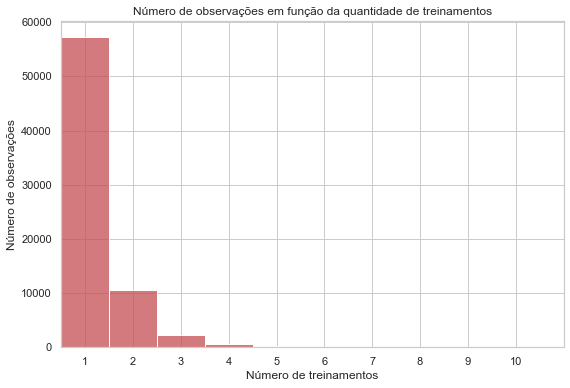

In [ ]:
plt.figure(figsize=[9,6])
sns.histplot(data=dfAnalise,x='no_of_trainings',discrete=True, color='r')
plt.title("Número de observações em função da quantidade de treinamentos")
ticks=[]
for i in range(11):
    ticks.append(i*1)
plt.xticks(ticks)
plt.xlim(left=0.5)
plt.xlabel("Número de treinamentos")
plt.ylabel("Número de observações")
plt.show()

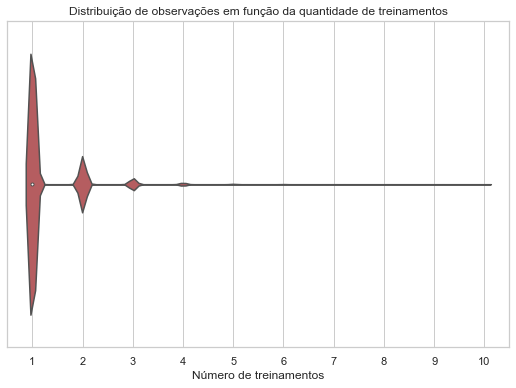

In [ ]:
plt.figure(figsize=[9,6])
sns.violinplot(data=dfAnalise,x='no_of_trainings', color='r')
plt.title("Distribuição de observações em função da quantidade de treinamentos")
ticks=[]
for i in range(11):
    ticks.append(i*1)
plt.xticks(ticks)
plt.xlim(0.5,10.5)
plt.xlabel("Número de treinamentos")
plt.show()

Analisando as informações acima, é evidente que as respostas estão bastante concentradas para 1 treinamento realizado e que a quantidade de pessoas com mais de 4 treinamentos é tão baixa que se torna irrelevante frente ao número presente nas outras respostas. Assim, para lidar com os dados faltantes, vamos substituí-los por 1 treinamento feito.

In [ ]:
dfAnalise['no_of_trainings'].fillna(1., inplace=True)

Agora, vamos ver a relação que a feature tem com o nosso target.

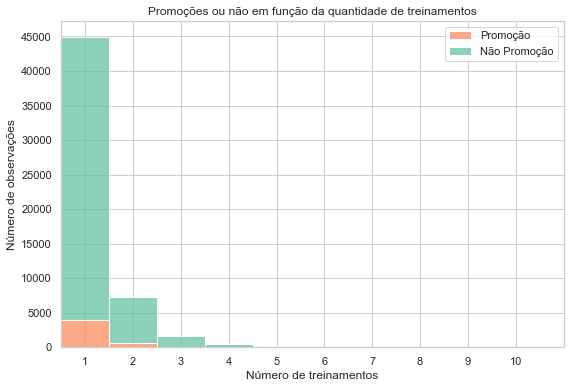

In [ ]:
plt.figure(figsize=[9,6])
sns.histplot(data=dfAnalise,x='no_of_trainings',hue='is_promoted', discrete=True, palette='Set2', multiple='stack')
plt.title("Promoções ou não em função da quantidade de treinamentos")
plt.legend(['Promoção', 'Não Promoção'])
ticks=[]
for i in range(11):
    ticks.append(i*1)
plt.xticks(ticks)
ticks.clear()
for j in range(10):
    ticks.append(j*5000)
plt.yticks(ticks)
plt.xlim(left=0.5)
plt.xlabel("Número de treinamentos")
plt.ylabel("Número de observações")
plt.show()

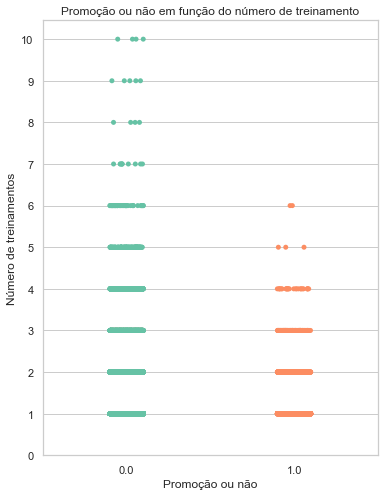

In [ ]:
plt.figure(figsize=[6,8])
sns.stripplot(data=dfAnalise, x='is_promoted',y='no_of_trainings',palette='Set2')
plt.title('Promoção ou não em função do número de treinamento')
ticks=[]
for i in range(11):
    ticks.append(i*1)
plt.yticks(ticks)
plt.xlabel('Promoção ou não')
plt.ylabel('Número de treinamentos')
plt.show()

In [ ]:
# Porcentagem de promoções por resposta
print((dfAnalise['no_of_trainings'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['no_of_trainings'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False))

1.0     8.758118
2.0     7.792208
3.0     6.892382
4.0     5.707763
6.0     5.000000
5.0     2.479339
7.0          NaN
8.0          NaN
9.0          NaN
10.0         NaN
Name: no_of_trainings, dtype: float64


Podemos ver que a partir de 7 treinamentos não temos mais nenhuma promoção, e que as pessoas com 1 treinamento são as que possuem mais promoções, absoluta e relativamente.
## Análise de **age**

In [ ]:
dfAnalise['age'].describe()

count     78036.000000
mean        202.453304
std        4545.727728
min         -32.000000
25%          29.000000
50%          33.000000
75%          39.000000
max      123456.000000
Name: age, dtype: float64

Analisando os dados acima, e como visto em Análise de dados numéricos, temos idades negativas e muito acima do aceitável. Assim, vamos excluir tais discrepâncias.

In [ ]:
dfAnalise = dfAnalise[(dfAnalise['age'] > 0) & (dfAnalise['age'] < 100)]
dfAnalise['age'].describe()

count    77927.000000
mean        34.807012
std          7.657812
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64

Agora, vemos que todos os dados são respostas condizentes com a feature trabalhada. Assim, podemos começar a análise da feature.

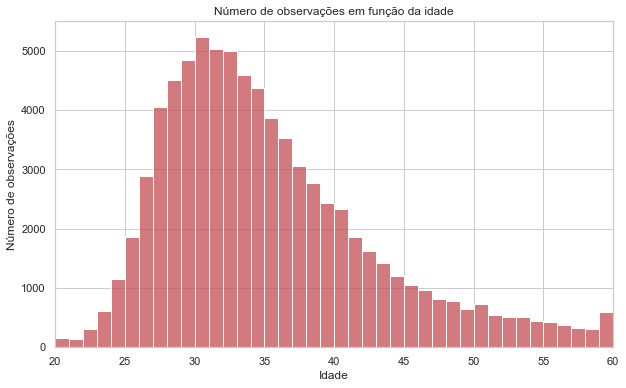

In [ ]:
plt.figure(figsize=[10,6])
sns.histplot(data=dfAnalise,x='age', color='r', bins=40)
plt.title("Número de observações em função da idade")
plt.xlim((20,60))
plt.xlabel("Idade")
plt.ylabel("Número de observações")
plt.show()

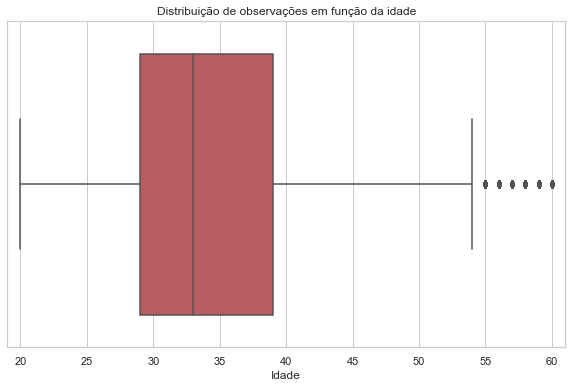

In [ ]:
plt.figure(figsize=[10,6])
sns.boxplot(data=dfAnalise,x='age', color='r')
plt.title("Distribuição de observações em função da idade")
plt.xlim((19,61))
plt.xlabel("Idade")
plt.show()

Observamos que a maioria das observações se concentra por volta dos 30 anos, e que, por isso, pessoas acima dos 55 anos são vistas como _outliers_ pelo gráfico de distribuição, entretanto, como visto anteriormente, tais observações são válidas sim, mesmo que estejam distantes da área de maior concentração não devem ser descartadas.
Vamos ver, agora, a relação que a feature tem com o target.

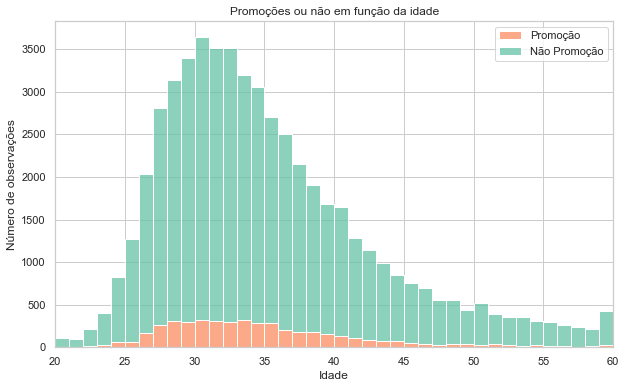

In [ ]:
plt.figure(figsize=[10,6])
sns.histplot(data=dfAnalise,x='age',hue='is_promoted',multiple='stack', palette='Set2', bins=40)
plt.title("Promoções ou não em função da idade")
plt.legend(['Promoção', 'Não Promoção'])
plt.xlim((20,60))
plt.xlabel("Idade")
plt.ylabel("Número de observações")
plt.show()

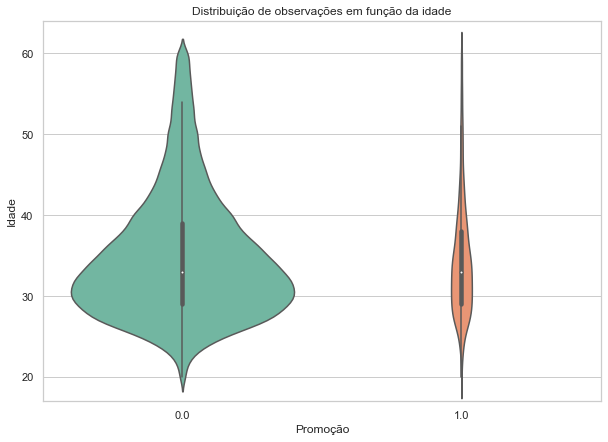

In [ ]:
plt.figure(figsize=[10,7])
sns.violinplot(data=dfAnalise, y='age', x='is_promoted', scale='count', palette='Set2')
plt.title("Distribuição de observações em função da idade")
plt.ylim((17,64))
plt.xlabel("Promoção")
plt.ylabel("Idade")
plt.show()

Analisando o obtido, temos que as promoções estão concentradas em torno dos 30 anos também. Temos, entretanto, que a quantidade relativa de promoções é bem parecidas entre as faixas etárias, com exceção das faixas etárias de menos de 25 anos e mais de 55 anos, aproximadamente. Mas, de forma geral, pode-se considerar que o número de promoções relativas é distribuído entre as idades.
## Análise de **previous_year_rating**

In [ ]:
dfAnalise['previous_year_rating'].describe()

count    72044.000000
mean         3.332935
std          1.261556
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: previous_year_rating, dtype: float64

In [ ]:
dfAnalise['previous_year_rating'].value_counts()

3.0    26377
5.0    16789
4.0    14078
1.0     8870
2.0     5930
Name: previous_year_rating, dtype: int64

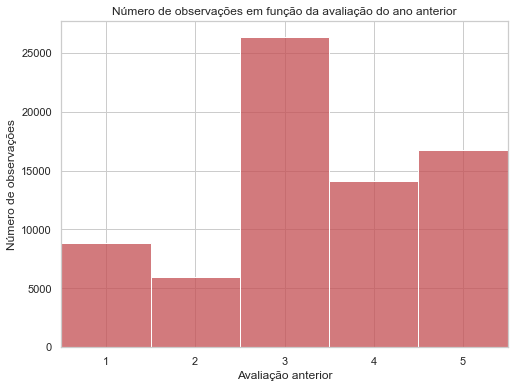

In [ ]:
plt.figure(figsize=[8,6])
sns.histplot(data=dfAnalise,x='previous_year_rating', discrete=True, color='r')
plt.title("Número de observações em função da avaliação do ano anterior")
plt.xlim((0.5,5.5))
plt.xlabel("Avaliação anterior")
plt.ylabel("Número de observações")
plt.show()

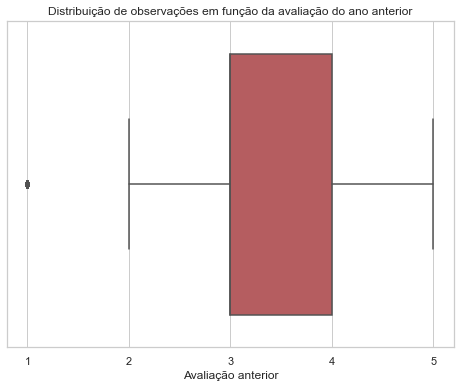

In [ ]:
plt.figure(figsize=[8,6])
sns.boxplot(data=dfAnalise,x='previous_year_rating', color='r')
plt.title("Distribuição de observações em função da avaliação do ano anterior")
ticks = list()
for i in range(1,6):
    ticks.append(i*1)
plt.xticks(ticks)
plt.xlabel("Avaliação anterior")
plt.show()

Vendo as informações acima, temos que a avaliação mais recorrente é 3. Assim, para tratar os dados faltantes da feature, iremos substituí-los por 3 nesse caso.

In [ ]:
dfAnalise['previous_year_rating'].fillna(3, inplace=True)

Vamos analisar a relação com o target.

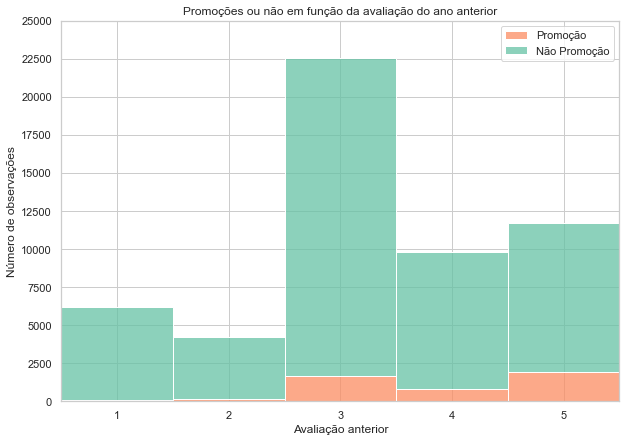

In [ ]:
plt.figure(figsize=[10,7])
sns.histplot(data=dfAnalise, x='previous_year_rating', discrete=True, hue='is_promoted', multiple='stack', palette='Set2')
plt.title("Promoções ou não em função da avaliação do ano anterior")
plt.legend(['Promoção', 'Não Promoção'])
plt.xlim((0.5, 5.5))
ticks = list()
for i in range(11):
    ticks.append(i*2500)
plt.yticks(ticks)
plt.xlabel("Avaliação anterior")
plt.ylabel("Número de observações")
plt.show()

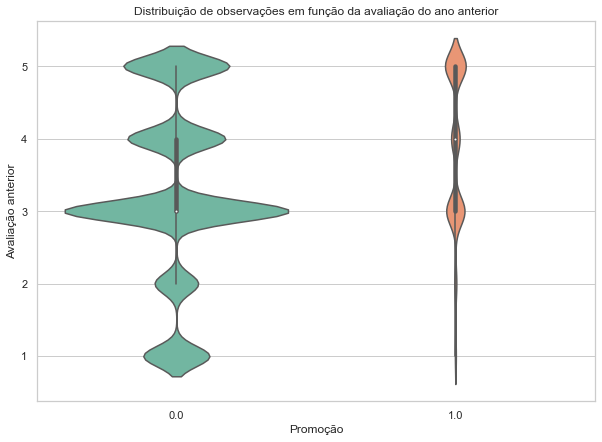

In [ ]:
plt.figure(figsize=[10,7])
sns.violinplot(data=dfAnalise, y='previous_year_rating', x='is_promoted', scale='count', palette='Set2')
plt.title("Distribuição de observações em função da avaliação do ano anterior")
plt.xlabel("Promoção")
plt.ylabel("Avaliação anterior")
plt.show()

In [ ]:
# Porcentagem de promoções por resposta
print((dfAnalise['previous_year_rating'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['previous_year_rating'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False))

5.0    16.350265
4.0     7.974774
3.0     7.470040
2.0     4.215289
1.0     1.421189
Name: previous_year_rating, dtype: float64


Observando as informações acima temos que a maior quantidade de promoções encontra-se na avaliação anterior 5, mesmo essa não sendo a com mais observações totais. Percebe-se também que a quantidade de promoções relativas é proporcional à avaliação, quanto maior a avaliação, maior a quantidade de promoções nela. Por isso, podemos concluir que tal feature tem impacto na promoção ou não do candidato.
## Análise de **length_of_service**

In [ ]:
dfAnalise['length_of_service'].describe()

count    77927.000000
mean         5.852003
std          4.245396
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         37.000000
Name: length_of_service, dtype: float64

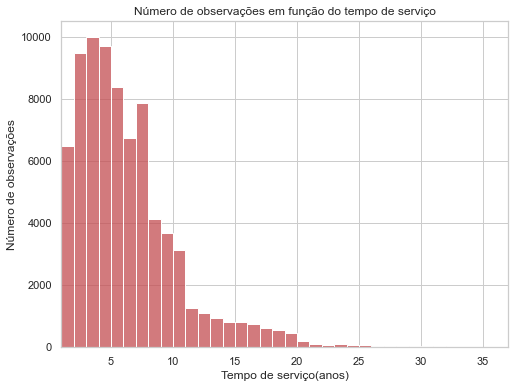

In [ ]:
plt.figure(figsize=[8,6])
sns.histplot(data=dfAnalise,x='length_of_service', color='r', bins = 36)
plt.title("Número de observações em função do tempo de serviço")
plt.xlim(1,37)
plt.xlabel("Tempo de serviço(anos)")
plt.ylabel("Número de observações")
plt.show()

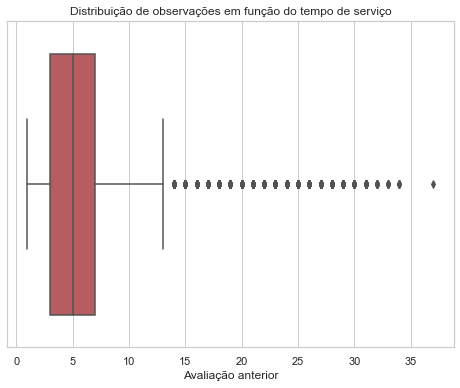

In [ ]:
plt.figure(figsize=[8,6])
sns.boxplot(data=dfAnalise,x='length_of_service', color='r')
plt.title("Distribuição de observações em função do tempo de serviço")
plt.xlabel("Avaliação anterior")
plt.show()

Temos que a maior concentração de dados se encontra até 7 anos de serviço, entretanto, tem-se um número considerável de observações até os 20 anos, a partir de onde a quantidade de dados começa a ficar irrelevante.
Agora, partimos para a relação com o target.

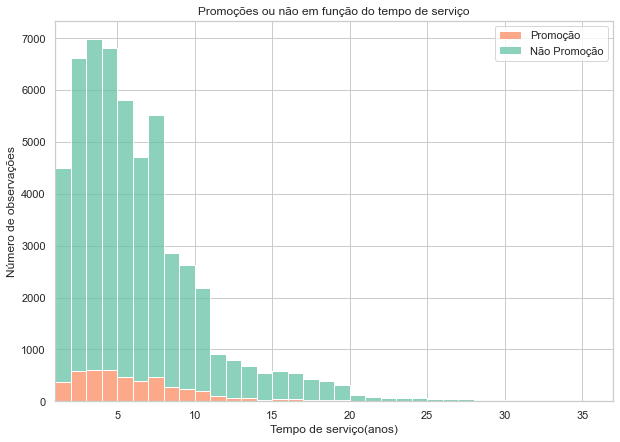

In [ ]:
plt.figure(figsize=[10,7])
sns.histplot(data=dfAnalise, x='length_of_service', hue='is_promoted', multiple='stack', palette='Set2', bins=36)
plt.title("Promoções ou não em função do tempo de serviço")
plt.legend(['Promoção', 'Não Promoção'])
plt.xlim((1, 37))
plt.xlabel("Tempo de serviço(anos)")
plt.ylabel("Número de observações")
plt.show()

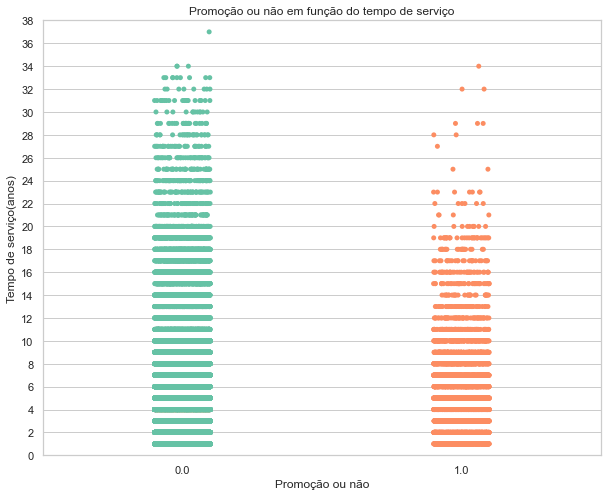

In [ ]:
plt.figure(figsize=[10,8])
sns.stripplot(data=dfAnalise, x='is_promoted',y='length_of_service',palette='Set2')
plt.title('Promoção ou não em função do tempo de serviço')
ticks = list()
for i in range(20):
    ticks.append(i*2)
plt.yticks(ticks)
plt.ylim((0,38))
plt.xlabel('Promoção ou não')
plt.ylabel('Tempo de serviço(anos)')
plt.show()

Percebe-se que as promoções estão concentradas até 10 anos de serviço, em que, a partir desse ponto, começa a cair significativamente. Em termos relativos, entretanto, não se tem muita diferença para o número de promoções com relação ao tempo de serviço.
## Análise de **avg_training_score**

In [ ]:
dfAnalise['avg_training_score'].describe()

count    70497.000000
mean        63.424614
std         13.470198
min         39.000000
25%         51.000000
50%         60.000000
75%         76.000000
max         99.000000
Name: avg_training_score, dtype: float64

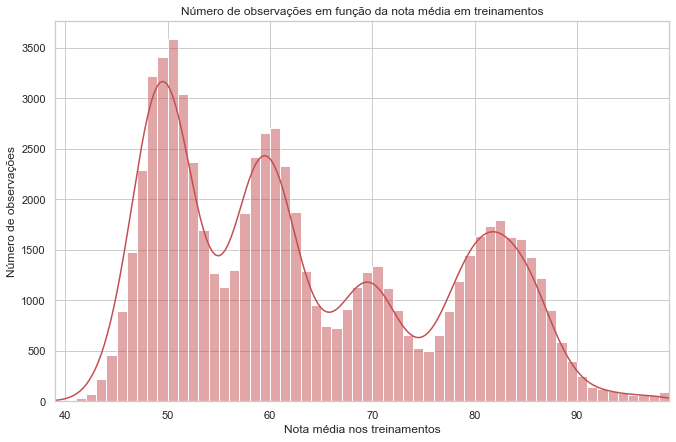

In [ ]:
plt.figure(figsize=[11,7])
sns.histplot(data=dfAnalise,x='avg_training_score', color='r', bins = 60, kde=True)
plt.title("Número de observações em função da nota média em treinamentos")
plt.xlim(39,99)
plt.xlabel("Nota média nos treinamentos")
plt.ylabel("Número de observações")
plt.show()

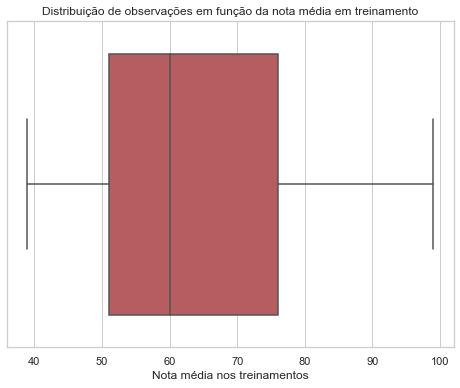

In [ ]:
plt.figure(figsize=[8,6])
sns.boxplot(data=dfAnalise,x='avg_training_score', color='r')
plt.title("Distribuição de observações em função da nota média em treinamento")
plt.xlabel("Nota média nos treinamentos")
plt.show()

Percebe-se que as observações estão bem distribuídas, tendo alguns picos de concentração, pontos de máximo, em torno dos 50 pontos, o maior pico de todos, e em torno dos 60, 70 e 80 pontos. Como os dados estão bem distribuídos, preencheremos os dados faltantes com o método `pad`(equivalente a `ffill`), em que ele preenche os dados faltantes baseados no último valor válido do dataframe. A ideia de usá-lo é que a grande distribuição das observações do dataframe analisado contribui para que dados faltantes, espalhados aleatoriamente nele, acabam por ter como referência valores distintos e presentes nos 4 núcleos de concentração de dados mencionados anteriormente, assim, a tendência é que ao substituir os dados faltantes com esse método, mantenhamos o aspecto ditribuído do gráfico, ao invés de substituir todos os dados faltantes por apenas 1 valor e gerar uma concentração. Temos certeza de que o método preencherá todos os dados faltantes porque, como visto em Análise inicial, os 5 primeiros valores de **avg_training_score** existe, assim, necessariamente, todos os dados faltantes tem um dado válido anterior a ele. Depois da alteração, faremos uma nova análise para ver se o método manteve a distribuição. 

In [ ]:
dfAnalise['avg_training_score'].fillna(method='pad',inplace=True)
dfAnalise['avg_training_score'].describe()

count    77927.000000
mean        63.447573
std         13.478784
min         39.000000
25%         51.000000
50%         60.000000
75%         76.000000
max         99.000000
Name: avg_training_score, dtype: float64

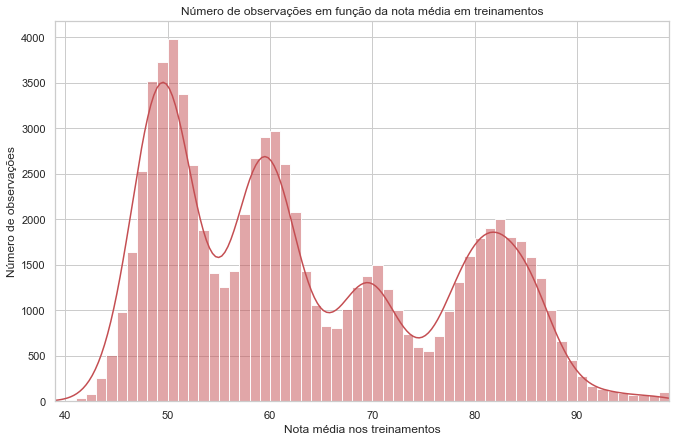

In [ ]:
plt.figure(figsize=[11,7])
sns.histplot(data=dfAnalise,x='avg_training_score', color='r', bins = 60, kde=True)
plt.title("Número de observações em função da nota média em treinamentos")
plt.xlim(39,99)
plt.xlabel("Nota média nos treinamentos")
plt.ylabel("Número de observações")
plt.show()

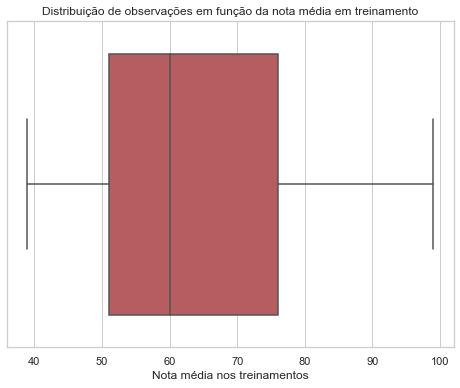

In [ ]:
plt.figure(figsize=[8,6])
sns.boxplot(data=dfAnalise,x='avg_training_score', color='r')
plt.title("Distribuição de observações em função da nota média em treinamento")
plt.xlabel("Nota média nos treinamentos")
plt.show()

Comparando as análises, vemos que, de fato, o comportamento e a distribuição das observações foram bem próximos. Agora, vamos analisar a relação da feature com o target.

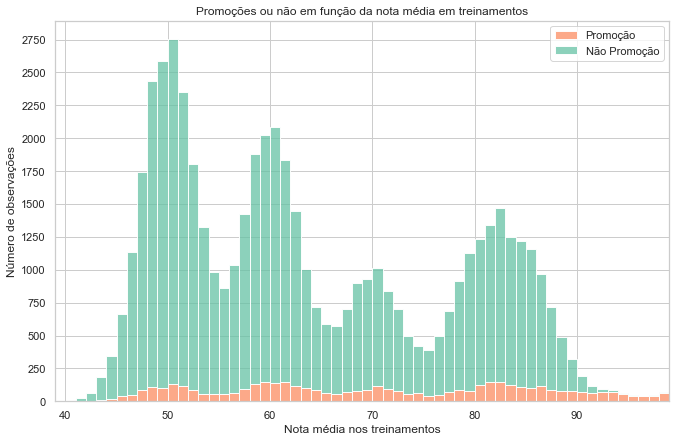

In [ ]:
plt.figure(figsize=[11,7])
sns.histplot(data=dfAnalise, x='avg_training_score', hue='is_promoted', multiple='stack', palette='Set2', bins=60)
plt.title("Promoções ou não em função da nota média em treinamentos")
plt.legend(['Promoção', 'Não Promoção'])
plt.xlim((39, 99))
ticks=list()
for i in range(12):
    ticks.append(i*250)
plt.yticks(ticks)
plt.xlabel("Nota média nos treinamentos")
plt.ylabel("Número de observações")
plt.show()

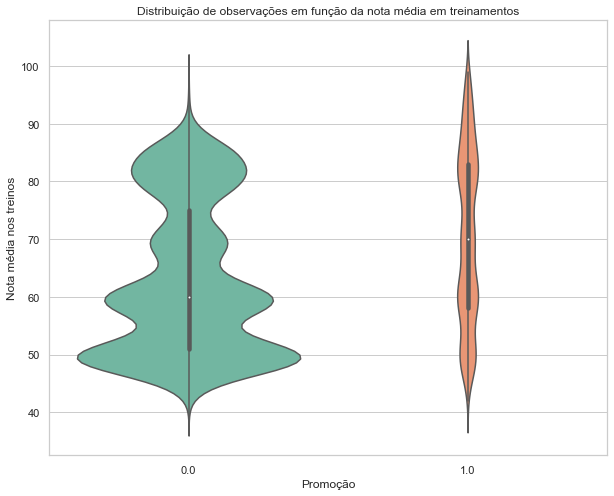

In [ ]:
plt.figure(figsize=[10,8])
sns.violinplot(data=dfAnalise, y='avg_training_score', x='is_promoted', scale='count', palette='Set2')
plt.title("Distribuição de observações em função da nota média em treinamentos")
plt.xlabel("Promoção")
plt.ylabel("Nota média nos treinos")
plt.show()

In [ ]:
# Porcentagem de promoções para cada resposta
dfPromocoesRel = (dfAnalise['avg_training_score'][dfAnalise['is_promoted'] == 1.0].value_counts()/dfAnalise['avg_training_score'][(dfAnalise['is_promoted'] == 1.0) | (dfAnalise['is_promoted'] == 0.0)].value_counts()*100).sort_values(ascending=False)
print(dfPromocoesRel.head(15))
print(dfPromocoesRel.tail(10))

99.0    93.750000
98.0    92.105263
97.0    91.666667
96.0    86.046512
94.0    80.000000
95.0    77.083333
93.0    76.404494
92.0    75.789474
91.0    53.389831
90.0    35.416667
89.0    23.510972
88.0    16.598361
74.0    15.566038
86.0    12.020725
87.0    11.764706
Name: avg_training_score, dtype: float64
48.0    4.515599
43.0    4.301075
53.0    4.295403
46.0    4.217926
44.0    4.069767
49.0    3.862495
42.0    3.333333
39.0         NaN
40.0         NaN
41.0         NaN
Name: avg_training_score, dtype: float64


Analisando os dados acima, temos que o número de promoções é quase que o mesmo para as notas médias, estando um pouco mais concentrados nas notas mais altas. Entretanto, enquanto o número absoluto de promoções é quase o mesmo, as observações totais tendem a diminuir com o aumento das notas, ou seja, temos para notas mais altas uma maior quantidade de promoções relativas, já para notas mais baixas esse número torna-se menor. Tal constatação é comprovada numericamente pela `Porcentagem de promoções para cada resposta`, em que as 15 maiores quantidades relativas de promoções se encontram, praticamente, nas 15 maiores notas, enquanto as 10 menores quantidades de promoções correspondem, praticamente, às 10 menores notas. Portanto, podemos concluir que a nota média nos treinamentos influencia para a promoção.

## Relação entre dados numéricos

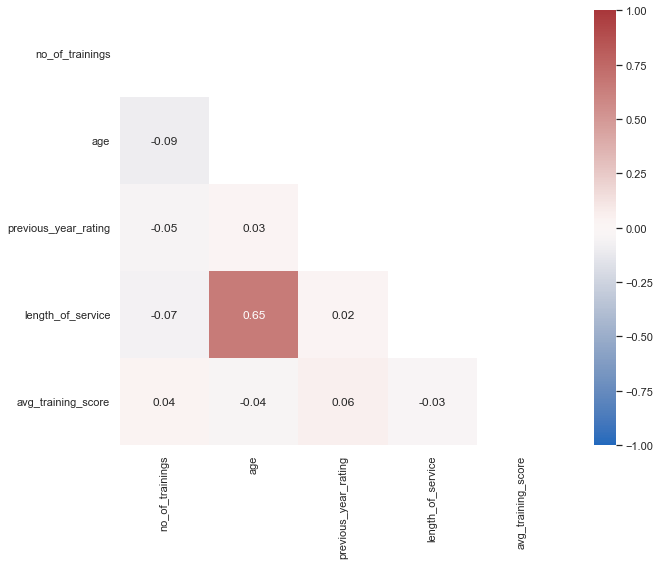

In [ ]:
plt.figure(figsize=[10,8])
corr = dfAnalise.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=corr, vmin=-1,vmax=1, center=0, cmap='vlag', mask=mask, annot=np.round(corr.values, 2))
plt.show()

Analisando o gráfico acima, temos que **age** e **length_of_service** tem correlação muito alta. Assim, vamos estudar tal relação mais a fundo.

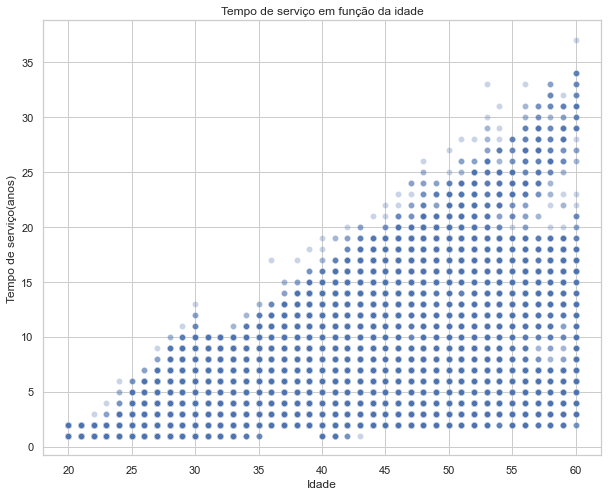

In [ ]:
plt.figure(figsize=[10,8])
sns.scatterplot(data=dfAnalise, x='age', y='length_of_service', alpha=0.3, palette='mako')
plt.title("Tempo de serviço em função da idade")
plt.xlabel("Idade")
plt.ylabel("Tempo de serviço(anos)")
plt.show()

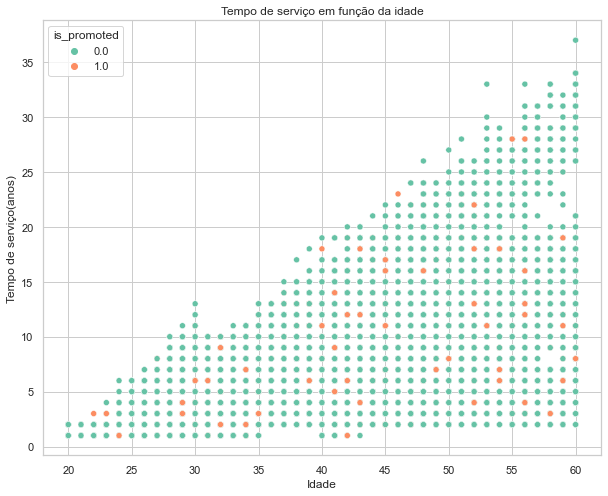

In [ ]:
plt.figure(figsize=[10,8])
sns.scatterplot(data=dfAnalise, x='age', y='length_of_service', hue='is_promoted', palette='Set2')
plt.title("Tempo de serviço em função da idade")
plt.xlabel("Idade")
plt.ylabel("Tempo de serviço(anos)")
plt.show()
sns.set_theme(style='white') # Tirar as graduações para gráficos fututos, em que tais marcações não são mais tão necessárias

Analisando os gráficos acima, percebemos que quanto conforme a idade das pessoas aumenta, o número de observações com tempo de serviço maior também. Entretanto, percebemos que tais dados não têm muita influência na target, visto que no último gráfico temos observações promovidas espalhadas ao longo de todas as idades e tempo de serviço, assim como visto nas análises individuais de cada uma das features.

## Conclusões dos dados numéricos
Feitas as análises podemos concluir que **avg_training_score** e **previous_year_rating** são as features que mais impactam no target, enquanto as outras não têm influência tão significativa para promoção ou não de alguma pessoa. Vimos, também, que **length_of_service** e **age** tem forte correlação, em que as observações com mais tempo de serviço aparecem à medida que a idade das observações aumenta.

# Conclusão da análise
Feitas as análises, podemos esperar que as features **awards_won?**, **department?**, **region**, **avg_training_score** e **previous_year_rating** tendem a impactar mais no target, e, portanto,  essas devem ser maioria dentre as features selecionadas para predição.
# Setup da predição
Baseado no que foi dito acima, atualizaremos os datasets `dfTrain` e `dfTest`, que serão usados para a predição, já com todas as alterações feitas durante a limpeza, trocando as variáveis categóricas por números através do *one_hot_encoding*, o que é feito através do método `get_dummies` do `pandas`, e, também, colocando as variáveis numéricas em mesma escala, visto que alguns dos modelos só funcionam corretamente, e outros têm sua performance melhorada, quando tais tipos de dados estão em mesma escala.

Para escolha das features, usaremos o método `SelectKBest`, em que ele seleciona as k melhores features a serem usadas para a predição, com base num dataset dado. Nesse caso, o dataset que usaremos como referência será o `dfTrain`, pois é nele em que temos o nosso target, para podermos decidir as melhores features, e, após descobertas tais features, deixaremos apenas essas nos 2 datasets.

In [ ]:
# Retirando as colunas que não serão utilizadas para a predição
#dfAnalise.drop(columns=['education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'length_of_service'], inplace=True)
#dfTest.drop(columns=['education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'length_of_service'], inplace=True)
#dfTrain.drop(columns=['education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'length_of_service'], inplace=True)

# Colocando as variáveis numéricas em mesma escala
from sklearn.preprocessing import MinMaxScaler
dfAnalise[['previous_year_rating', 'avg_training_score', 'no_of_trainings', 'age', 'length_of_service']] = MinMaxScaler().fit_transform(dfAnalise[['previous_year_rating', 'avg_training_score', 'no_of_trainings', 'age', 'length_of_service']])


#Atualizando os dataframes de teste e treino
dfTest.set_index('employee_id', inplace=True)
dfTrain.set_index('employee_id', inplace=True)
setTest = set(dfTest.index)
setTrain = set(dfTrain.index)
setAnaly = set(dfAnalise.index)
Intersec1 = setTest.intersection(setAnaly)
Intersec2 = setTrain.intersection(setAnaly)
dfTest = dfTest.loc[list(Intersec1)]
dfTrain = dfTrain.loc[list(Intersec2)]
dfTest.update(dfAnalise)
dfTrain.update(dfAnalise)

In [ ]:
# Trocando as variáveis categóricas por números
dfTrain = pd.get_dummies(dfTrain)
dfTrain['is_promoted'] = dfTrain['is_promoted_1.0']
dfTrain.drop(columns=['is_promoted_0.0', 'is_promoted_1.0'], inplace=True)
dfTest = pd.get_dummies(dfTest)

In [ ]:
# Selecionando as k melhores features, nesse caso, com k=20
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
selector = SelectKBest(score_func=chi2, k = 10).fit(dfTrain.drop(columns='is_promoted'), dfTrain['is_promoted'])
featuresExcluidas = list()
for i in range(57):
    if i not in selector.get_support(indices=True):
        featuresExcluidas.append(i)
dfTrain.drop(columns=dfTrain.columns[featuresExcluidas], inplace=True)
dfTest.drop(columns=dfTest.columns[featuresExcluidas], inplace=True)

In [ ]:
dfTrain.head(1)

,previous_year_rating,avg_training_score,department_Sales & Marketing,department_Technology,region_region_22,region_region_4,region_region_7,education_Master's & above,awards_won?_0,awards_won?_1,is_promoted
employee_id,,,,,,,,,,,
1,0.5,0.766667,0,0,0,0,1,0,1,0,0


Agora que os dataframes foram atualizados, vamos dividir o dataset `dfTrain` em 2, um de treino e outro de teste, que servirão para avaliar os modelos criados, enquanto o dataset `dfTest` será usado, apenas, para a predição final. Como no caso desse dataset temos as observações do target muito desequilibradas, usaremos o parâmetro `stratify` para garantir que a proporção da classe alvo seja parecida em ambos as distribuições criadas. 

In [ ]:
from sklearn.model_selection import train_test_split
x = dfTrain.drop(columns=['is_promoted'])
y = dfTrain['is_promoted']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state= 27, stratify=y, test_size= 0.25)

Vamos, agora, elaborar diversos tipos de modelos de predição e avaliá-los com base em algumas métricas. Feito isso, escolheremos aquele mais adequado para a predição do dataset `dfTest`. 

# Modelos de predição
Agora que já analisamos, limpamos e atualizamos os dados presentes nos datasets de treino e teste, podemos elaborar um modelo para a promoção, ou não, de um funcionário. 

Uma característica importante do nosso dataset é a distibuição dos dados com relação ao target, pois esses são muito desbalanceados, ou seja, temos uma resposta com frequência bem maior que a outra. Tal fato faz com que o modelo, naturalmente, tenha uma acurácia alta, pois, se ele só predisser a classe com maior frequência, por exemplo, ele tem um bom índice de acertos. Assim, para amenizar tal problema, usaremos 2 saídas:
- A primeira é atribuir pesos diferentes a classes, em que a classe com menor frequência terá um peso maior, visto que isso força o modelo a pririzar a classe menos frequente e minimizar os erros referentes a essa, faremos isso usando o parâmetro `class_weight` presente em alguns modelos;
- A segunda é usar a técnica de *resample* que consiste em igualar a frequência de cada resposta, para o dataset de treino, evitando vazamento de dados, e, com isso, garantir que o modelo dê igual importância às classes. Trabalharemos com *oversample*, que consiste em criar observações pertencentes à classe menos frequente, fazendo isso com o método `resample` do `sklearn`. Usaremos tal estratégia para os modelos que não possuem o parâmetro `class_weight`.

A métrica que utilizaremos para avaliar o modelo será o **f1**. Isso porque consideramos que falsos positivos e falsos negativos têm a mesma importância e queremos focar em diminuí-los ao máximo.

Para otimização dos modelos trabalhados, nesse caso, aquele com maior valor de **f1**, utilizaremos o método `HalvingGridSearchCV`, que é semelhante ao `GridSearch`, entretanto com tempo de execução menor, pois, ao invés de comparar os hiperparâmetros para todo o dataset de uma vez, esse o divide em *subsets* e testa tais hiperparâmetros em uma menor quantidade de dados, escolhendo aqueles com maior eficácia para analisar em uma maior quantidade de dados. Para a otimizização dos modelos, passaremos para a função apenas alguns parâmetros do modelo, aqueles que julgar mais importantes, pois, caso contrário, o tempo de execução seria muito alto.

Por fim, encontrado o modelo que melhor satisfaz o problema, calcularemos, ainda, seu threshold ideal, ou seja, aquele que maximiza ainda mais o **f1** do modelo.

In [ ]:
# Importação para otimização dos modelos
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
# Importação das métricas utilizadas
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Ressample do dataset destinado ao treino do modelo
from sklearn.utils import resample
dfTreino = pd.DataFrame(x_train)
dfTreino = dfTreino.join(pd.DataFrame(y_train), how='outer')
dfMaioria = dfTreino[(dfTreino['is_promoted'] == 0)]
dfMinoria = dfTreino[dfTreino['is_promoted'] == 1]
dfMinoria = resample(dfMinoria, n_samples=dfMaioria.shape[0], replace=True)
dfRessample = pd.concat([dfMaioria, dfMinoria])
r_train , r_test, yr_train, yr_test = train_test_split(dfRessample.drop(columns='is_promoted'), dfRessample['is_promoted'], test_size=0.01)

## Regressão logística

Primeiramente, faremos a otimização dos parâmetros com o auxílio de `HalvingGridSearchCV`. Por fim, buscaremos o threshold que maxima o **fbeta** da predição do modelo.

In [ ]:
from sklearn.linear_model import LogisticRegression
# Obtendo os melhores parâmetros
pesos = np.linspace(0.0, 0.50, 51)
cvOtimizacao = StratifiedKFold()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'sag']
space['C'] = [1e-3, 1e-2, 1e-1, 1, 10]
space['penalty'] = ['l2', 'none']
space['class_weight'] = [{0:peso, 1: 1-peso} for peso in pesos]
search = HalvingGridSearchCV(LogisticRegression(), space, cv=cvOtimizacao, scoring='f1')
logReg = search.fit(x_train, y_train)
print(f'Maior f1 obtido no treino: {logReg.best_score_*100:.2f}%')
print(f'Melhores parametros: {logReg.best_params_}')

Maior f1 obtido no treino: 30.83%
Melhores parametros: {'C': 0.001, 'class_weight': {0: 0.13, 1: 0.87}, 'penalty': 'none', 'solver': 'sag'}


In [ ]:
# Encontrando o threshold ótimo para o modelo
y_predictProb = logReg.predict_proba(x_test)
threshold = 0.2
f1 = 0
while threshold <= 0.7:
    temp_predicted = (y_predictProb[:,1] >= threshold).astype('int')
    temp_f1 = f1_score(y_test, temp_predicted)
    if temp_f1 > f1:
        f1 = temp_f1
        thresholdOtimo = threshold
    threshold += 0.01
print(f'Melhor threshold encontrado: {thresholdOtimo:.2f}')

Melhor threshold encontrado: 0.58


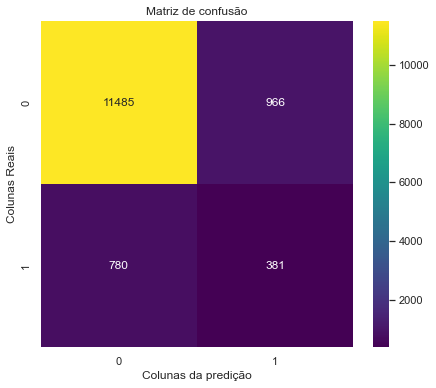

Precisão obtida no teste: 28.29%
Acuracia obtida no teste: 87.17%
Sensitividade obtida no teste: 32.82%
F1 obtido no teste: 30.38%


In [ ]:
# Ajustando a predição para  considerar o threshold encontrado acima
y_predict = pd.Series(y_predictProb[:,1]).map(lambda x:1 if x > thresholdOtimo else 0)

# Métricas para o modelo
cm = confusion_matrix(y_test, y_predict)
fig, (ax) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'viridis')
ax.set_xlabel('Colunas da predição')
ax.set_ylabel('Colunas Reais')
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

print(f'Precisão obtida no teste: {precision_score(y_test, y_predict)*100:.2f}%')
print(f'Acuracia obtida no teste: {accuracy_score(y_test, y_predict)*100:.2f}%')
print(f'Sensitividade obtida no teste: {recall_score(y_test, y_predict)*100:.2f}%')
print(f'F1 obtido no teste: {f1_score(y_test, y_predict)*100:.2f}%')


Analisando o modelo, vemos que a **f1** atingiu um valor um pouco maior que 30%, sendo que a precisão foi um pouco menor que 30%, já a sensitividade foi de 32%, a acurácia, por sua vez, obteve um valor elevado, um pouco mais que 87%, algo esperado tendo em vista o dataset trabalhado. Assim, o modelo está longe de ser o ideal, mas é razoável.
## Árvore de decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Obtendo os melhores parâmetros
pesos = np.linspace(0.0, 0.50, 51)
cvOtimizacao = StratifiedKFold()
space = dict()
space['max_features'] = [2, 3, 4, 5, 6, 7, 8, 9, 10]
space['max_depth'] = [4, 6, 8, 10, 12, 14, 16, 18]
space['class_weight'] = [{0:peso, 1: 1-peso} for peso in pesos]
search = HalvingGridSearchCV(DecisionTreeClassifier(), space, cv=cvOtimizacao, scoring='f1')
decTree = search.fit(x_train, y_train)
print(f'Maior f1 obtido no treino: {decTree.best_score_*100:.2f}%')
print(f'Melhores parametros: {decTree.best_params_}')

Maior f1 obtido no treino: 34.50%
Melhores parametros: {'class_weight': {0: 0.21, 1: 0.79}, 'max_depth': 6, 'max_features': 10}


In [ ]:
# Encontrando o threshold ótimo para o modelo
y_predictProb = decTree.predict_proba(x_test)
threshold = 0.2
f1 = 0
while threshold <= 0.7:
    temp_predicted = (y_predictProb[:,1] >= threshold).astype('int')
    temp_f1 = f1_score(y_test, temp_predicted)
    if temp_f1 > f1:
        f1 = temp_f1
        thresholdOtimo = threshold
    threshold += 0.01
print(f'Melhor threshold encontrado: {thresholdOtimo:.2f}')

Melhor threshold encontrado: 0.43


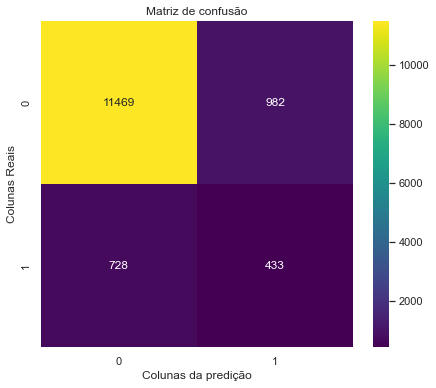

Precisão obtida no teste: 30.60%
Acuracia obtida no teste: 87.44%
Sensitividade obtida no teste: 37.30%
F1 obtido no teste: 33.62%


In [ ]:
# Ajustando a predição para  considerar o threshold encontrado acima
y_predict = pd.Series(y_predictProb[:,1]).map(lambda x:1 if x > thresholdOtimo else 0)

#Métricas para o modelo
cm = confusion_matrix(y_test, y_predict)
fig, (ax) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'viridis')
ax.set_xlabel('Colunas da predição')
ax.set_ylabel('Colunas Reais')
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

print(f'Precisão obtida no teste: {precision_score(y_test, y_predict)*100:.2f}%')
print(f'Acuracia obtida no teste: {accuracy_score(y_test, y_predict)*100:.2f}%')
print(f'Sensitividade obtida no teste: {recall_score(y_test, y_predict)*100:.2f}%')
print(f'F1 obtido no teste: {f1_score(y_test, y_predict)*100:.2f}%')

Analisando o modelo, vemos que esse já apresentou melhores métricas do que o modelo anterior, tendo um aumento de 3% no **f1**, 2% para a precisão, 5% para sensitividade e 0,3% para acurácia. Assim podemos concluir que tal modelo se mostrou mais eficaz do que o modelo de regressão logística.
## Random forest

Como o modelo de **Random forest** consiste em treinar diversas árvores de decisão e fazer a predição com base na resposta que mais aparece nas árvores, para os parâmetros de tal modelo relacionados à construção das árvores, colocaremos menos opções de hiperparâmetros, comparado à quantidade presente no modelo da Árvore de decisão, e colocaremos uma quantidade de árvores não tão grande na floresta, pois, caso contrário, o tempo de execução seria muito longo. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Obtendo os melhores parâmetros
pesos = np.linspace(0.0, 0.49, 50)
cvOtimizacao = StratifiedKFold()
space = dict()
space['max_depth'] = [4, 6, 8, 10, 12]
space['max_features'] = [4, 5, 6, 7, 8, 9, 10]
space['class_weight'] = [{0:peso, 1: 1-peso} for peso in pesos]
search = HalvingGridSearchCV(RandomForestClassifier(n_estimators=15), space, cv=cvOtimizacao, scoring='f1', factor=5)
randForest = search.fit(x_train, y_train)
print(f'Maior f1 obtido no treino: {randForest.best_score_*100:.2f}%')
print(f'Melhores parametros: {randForest.best_params_}')

Maior f1 obtido no treino: 34.66%
Melhores parametros: {'class_weight': {0: 0.14, 1: 0.86}, 'max_depth': 6, 'max_features': 4}


In [ ]:
# Encontrando o threshold ótimo para o modelo
y_predictProb = randForest.predict_proba(x_test)
threshold = 0.2
f1 = 0
while threshold <= 0.7:
    temp_predicted = (y_predictProb[:,1] >= threshold).astype('int')
    temp_f1 = f1_score(y_test, temp_predicted)
    if temp_f1 > f1:
        f1 = temp_f1
        thresholdOtimo = threshold
    threshold += 0.01
print(f'Melhor threshold encontrado: {thresholdOtimo:.2f}')

Melhor threshold encontrado: 0.56


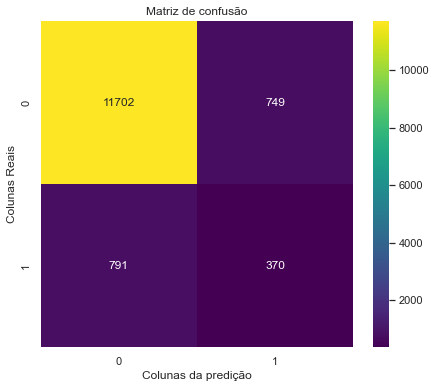

Precisão obtida no teste: 33.07%
Acuracia obtida no teste: 88.69%
Sensitividade obtida no teste: 31.87%
F1 obtido no teste: 32.46%


In [ ]:
# Ajustando a predição para  considerar o threshold encontrado acima
y_predict = pd.Series(y_predictProb[:,1]).map(lambda x:1 if x > thresholdOtimo else 0)

#  Métricas para o modelo
cm = confusion_matrix(y_test, y_predict)
fig, (ax) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'viridis')
ax.set_xlabel('Colunas da predição')
ax.set_ylabel('Colunas Reais')
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

print(f'Precisão obtida no teste: {precision_score(y_test, y_predict)*100:.2f}%')
print(f'Acuracia obtida no teste: {accuracy_score(y_test, y_predict)*100:.2f}%')
print(f'Sensitividade obtida no teste: {recall_score(y_test, y_predict)*100:.2f}%')
print(f'F1 obtido no teste: {f1_score(y_test, y_predict)*100:.2f}%')

Vemos que o modelo obteve métricas boas também, comparando com os resultados encontrados até agora, tendo uma acurácia 1% maior e aumento na precisão de 3%, enquanto tal modelo obteve uma piora de quase 6% na sensitividade e de 1% no **f1**. Assim, para esse caso, mesmo sendo bem parecidos, consideraremos a árvore de decisão mais adequada que o modelo de Random forest.
## KNN(K-Nearest Neighbors)

O KNN não apresenta o parâmetro `class_weight`, assim, treinaremos ele no dataset em que fizemos *oversample*.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Obtendo os melhores parâmetros
cvOtimizacao = StratifiedKFold()
space = dict()
space['n_neighbors'] = range(1, 21)
space['weights'] = ['uniform', 'distance']
space['p'] = [1, 2]
search = HalvingGridSearchCV(KNeighborsClassifier(), space, cv=cvOtimizacao, scoring='f1', factor = 4)
knn = search.fit(r_train, yr_train)
print(f'Maior f1 obtido no treino: {knn.best_score_*100:.2f}%')
print(f'Melhores parametros: {knn.best_params_}')

Maior f1 obtido no treino: 74.21%
Melhores parametros: {'n_neighbors': 17, 'p': 2, 'weights': 'distance'}


In [ ]:
# Encontrando o threshold ótimo para o modelo
y_predictProb = knn.predict_proba(x_test)
threshold = 0.2
f1 = 0
while threshold <= 0.7:
    temp_predicted = (y_predictProb[:,1] >= threshold).astype('int')
    temp_f1 = f1_score(y_test, temp_predicted)
    if temp_f1 > f1:
        f1 = temp_f1
        thresholdOtimo = threshold
    threshold += 0.01
print(f'Melhor threshold encontrado: {thresholdOtimo:.2f}')

Melhor threshold encontrado: 0.66


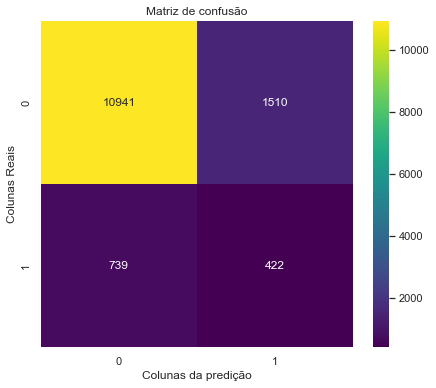

Precisão obtida no teste: 21.84%
Acuracia obtida no teste: 83.48%
Sensitividade obtida no teste: 36.35%
F1 obtido no teste: 27.29%


In [ ]:
# Ajustando a predição para  considerar o threshold encontrado acima
y_predict = pd.Series(y_predictProb[:,1]).map(lambda x:1 if x > thresholdOtimo else 0)

# Métricas para o modelo
cm = confusion_matrix(y_test, y_predict)
fig, (ax) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'viridis')
ax.set_xlabel('Colunas da predição')
ax.set_ylabel('Colunas Reais')
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

print(f'Precisão obtida no teste: {precision_score(y_test, y_predict)*100:.2f}%')
print(f'Acuracia obtida no teste: {accuracy_score(y_test, y_predict)*100:.2f}%')
print(f'Sensitividade obtida no teste: {recall_score(y_test, y_predict)*100:.2f}%')
print(f'F1 obtido no teste: {f1_score(y_test, y_predict)*100:.2f}%')

Analisando as informações acima, vemos que o modelo de KNN tem uma precisão muita baixa e, também, possui a pior acurácia e o pior f1 dentre os modelos vistos até agora. O ponto positivo do modelo é sua sensitividade, que foi uma das maiores encontradas. Assim, concluímos que tal modelo não se mostra adequado para o problema em questão.
## Naive Bayes

Temos vários modelos de Naive Bayes, nesse caso, trabalharemos com o Complement Naive Bayes, que é um modelo próprio para dados desbalanceados, e o Multinomial Naive Bayes treinado em cima do dataset com *oversample*

## Complement Naive Bayes

In [ ]:
from sklearn.naive_bayes import ComplementNB
# Obtendo os melhores parâmetros
alpha = np.linspace(0.01, 1, 100)
cvOtimizacao = StratifiedKFold()
space = dict()
space['alpha'] = alpha
search = HalvingGridSearchCV(ComplementNB(), space, cv=cvOtimizacao, scoring='f1', factor=2)
cnb = search.fit(x_train, y_train)
print(f'Maior f1 obtido no treino: {cnb.best_score_*100:.2f}%')
print(f'Melhores parametros: {cnb.best_params_}')

Maior f1 obtido no treino: 22.19%
Melhores parametros: {'alpha': 0.4}


In [ ]:
# Encontrando o threshold ótimo para o modelo
y_predictProb = cnb.predict_proba(x_test)
threshold = 0.2
f1 = 0
while threshold <= 0.7:
    temp_predicted = (y_predictProb[:,1] >= threshold).astype('int')
    temp_f1 = f1_score(y_test, temp_predicted)
    if temp_f1 > f1:
        f1 = temp_f1
        thresholdOtimo = threshold
    threshold += 0.01
print(f'Melhor threshold encontrado: {thresholdOtimo:.2f}')

Melhor threshold encontrado: 0.53


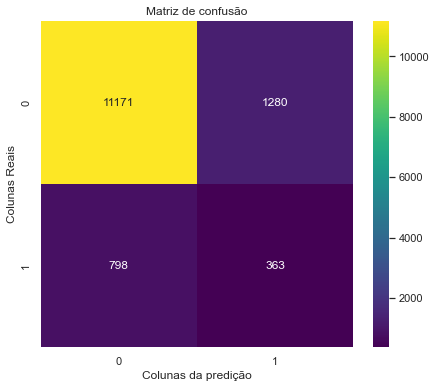

Precisão obtida no teste: 22.09%
Acuracia obtida no teste: 84.73%
Sensitividade obtida no teste: 31.27%
F1 obtido no teste: 25.89%


In [ ]:
# Ajustando a predição para  considerar o threshold encontrado acima
y_predict = pd.Series(y_predictProb[:,1]).map(lambda x:1 if x > thresholdOtimo else 0)

#  Métricas para o modelo
cm = confusion_matrix(y_test, y_predict)
fig, (ax) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'viridis')
ax.set_xlabel('Colunas da predição')
ax.set_ylabel('Colunas Reais')
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

print(f'Precisão obtida no teste: {precision_score(y_test, y_predict)*100:.2f}%')
print(f'Acuracia obtida no teste: {accuracy_score(y_test, y_predict)*100:.2f}%')
print(f'Sensitividade obtida no teste: {recall_score(y_test, y_predict)*100:.2f}%')
print(f'F1 obtido no teste: {f1_score(y_test, y_predict)*100:.2f}%')

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# Obtendo os melhores parâmetros
alpha = np.linspace(0.01, 1, 100)
cvOtimizacao = StratifiedKFold()
space = dict()
space['alpha'] = alpha
search = HalvingGridSearchCV(MultinomialNB(), space, cv=cvOtimizacao, scoring='f1', factor=2)
mnb = search.fit(r_train, yr_train)
print(f'Maior f1 obtido no treino: {mnb.best_score_*100:.2f}%')
print(f'Melhores parametros: {mnb.best_params_}')

Maior f1 obtido no treino: 55.04%
Melhores parametros: {'alpha': 0.75}


In [ ]:
# Encontrando o threshold ótimo para o modelo
y_predictProb = mnb.predict_proba(x_test)
threshold = 0.2
f1 = 0
while threshold <= 0.7:
    temp_predicted = (y_predictProb[:,1] >= threshold).astype('int')
    temp_f1 = f1_score(y_test, temp_predicted)
    if temp_f1 > f1:
        f1 = temp_f1
        thresholdOtimo = threshold
    threshold += 0.01
print(f'Melhor threshold encontrado: {thresholdOtimo:.2f}')

Melhor threshold encontrado: 0.53


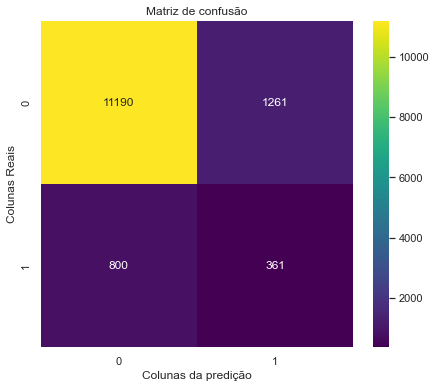

Precisão obtida no teste: 22.26%
Acuracia obtida no teste: 84.86%
Sensitividade obtida no teste: 31.09%
F1 obtido no teste: 25.94%


In [ ]:
# Ajustando a predição para  considerar o threshold encontrado acima
y_predict = pd.Series(y_predictProb[:,1]).map(lambda x:1 if x > thresholdOtimo else 0)

#  Métricas para o modelo
cm = confusion_matrix(y_test, y_predict)
fig, (ax) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'viridis')
ax.set_xlabel('Colunas da predição')
ax.set_ylabel('Colunas Reais')
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

print(f'Precisão obtida no teste: {precision_score(y_test, y_predict)*100:.2f}%')
print(f'Acuracia obtida no teste: {accuracy_score(y_test, y_predict)*100:.2f}%')
print(f'Sensitividade obtida no teste: {recall_score(y_test, y_predict)*100:.2f}%')
print(f'F1 obtido no teste: {f1_score(y_test, y_predict)*100:.2f}%')

Vemos que os dois modelos apresentaram métricas extremamente parecidas, ambos obtiveram **f1**, precisão e acurácia baixos, e um valor razoável, dentro do panorama dos modelos anteriores, para a sensitividade.

## SVM(Suport Vector Machines)

Para o modelo SVM não iremos procurar o threshold ótimo, visto que as probabilidades retornadas pelo método podem ser inconsistentes com o que ele prediz na verdade.

In [ ]:
from sklearn.svm import SVC
# Obtendo os melhores parâmetros
pesos = np.linspace(0.0, 0.49, 50)
cvOtimizacao = StratifiedKFold()
space = dict()
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = [{0:peso, 1: 1-peso} for peso in pesos]
search = HalvingGridSearchCV(SVC(), space, cv=cvOtimizacao, scoring='f1')
svm = search.fit(x_train, y_train)
print(f'Maior f1 obtido no treino: {svm.best_score_*100:.2f}%')
print(f'Melhores parametros: {svm.best_params_}')

Maior f1 obtido no treino: 32.37%
Melhores parametros: {'C': 1, 'class_weight': {0: 0.12, 1: 0.88}, 'kernel': 'poly'}


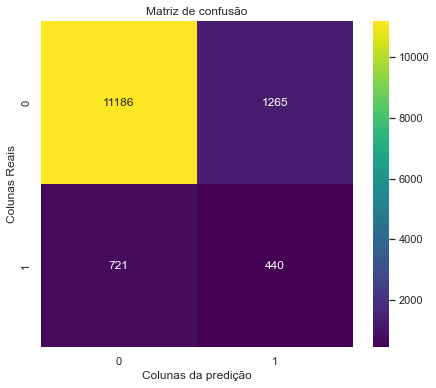

Precisão obtida no teste: 25.81%
Acuracia obtida no teste: 85.41%
Sensitividade obtida no teste: 37.90%
F1 obtido no teste: 30.70%


In [ ]:
# Ajustando a predição para  considerar o threshold encontrado acima
y_predict = svm.predict(x_test)

#  Métricas para o modelo
cm = confusion_matrix(y_test, y_predict)
fig, (ax) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'viridis')
ax.set_xlabel('Colunas da predição')
ax.set_ylabel('Colunas Reais')
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

print(f'Precisão obtida no teste: {precision_score(y_test, y_predict)*100:.2f}%')
print(f'Acuracia obtida no teste: {accuracy_score(y_test, y_predict)*100:.2f}%')
print(f'Sensitividade obtida no teste: {recall_score(y_test, y_predict)*100:.2f}%')
print(f'F1 obtido no teste: {f1_score(y_test, y_predict)*100:.2f}%')

Vemos que tal modelo foi o que obteve a maior sensitividade, entretanto a precisão não foi tão elevada, quase 26%. Mesmo assim, o SVM conseguiu obter **f1** de quase 31%, o que, dentre os valores obtidos para os modelos anteriores, é um resultado razoável, assim como a acurácia atingida. Portanto, o modelo não é o modelo mais adequado para o proposto.

# Conclusão sobre os modelos e predição final
Depois de uma análise comparativa entre os modelos, escolhemos o modelo da **Árvore de decisão** como o mais apropriado dentre os modelos estudados. Então, vamos fazer a predição do dataset `dfTest` com o modelo escolhido e visualizar um pouco da predição.

In [ ]:
finalPredictProb = decTree.predict_proba(dfTest)
# Usaremos o threshold ótimo encontrado para a árvore de decisão, que foi 0.53
finalPredict = pd.Series(finalPredictProb[:,1]).map(lambda x:1 if x > 0.53 else 0)
finalPredict

0        0
1        0
2        0
3        0
4        0
        ..
23476    0
23477    0
23478    1
23479    0
23480    0
Length: 23481, dtype: int64

In [ ]:
finalPredict = pd.DataFrame(finalPredict)
print(finalPredict.value_counts())

0    21948
1     1533
dtype: int64
